In [2]:
import numpy as np

import pandas as pd
from sklearn.preprocessing import MinMaxScaler

from gtda.time_series import takens_embedding_optimal_parameters, TakensEmbedding
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceLandscape
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv("../data/base_macro_con_pib.csv")

# Convertir columna de fechas a tipo datetime
data["Fecha"] = pd.to_datetime(data["Fecha"])

# Definirla como índice temporal
data.set_index("Fecha", inplace=True)

scaler = MinMaxScaler()
data_norm = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)

In [4]:
# Step 1: Takens Embedding
data_multi = data_norm.values.T[np.newaxis, :, :]  # (1, 7, 204)

takens_multi = TakensEmbedding(
    time_delay=3,
    dimension=5,
    stride=1,
    flatten=True,
    ensure_last_value=True
)

embedded_multi = takens_multi.fit_transform(data_multi)
print("Embedded (multi):", embedded_multi.shape)  # (1, n_windows, 35)

# Step 2: Compute Persistence Diagrams
vr_multi = VietorisRipsPersistence(
    homology_dimensions=[0, 1, 2],
    n_jobs=-1
)

diagrams_multi = vr_multi.fit_transform(embedded_multi)
print("Diagrams (multi):", diagrams_multi.shape)  # (1, n_features, 3)

# Step 3: Compute Persistence Landscapes
landscape_multi = PersistenceLandscape(
    n_layers=5,
    n_bins=100,
    n_jobs=-1
)

landscapes_multi = landscape_multi.fit_transform(diagrams_multi)
print("Landscapes (multi):", landscapes_multi.shape)  
# Shape: (1, n_homology_dimensions * n_layers, n_bins)
# If you have 3 homology dimensions (0, 1, 2) and 5 layers:
# Shape will be: (1, 3*5, 100) = (1, 15, 100)

Embedded (multi): (1, 192, 35)
Diagrams (multi): (1, 213, 3)
Landscapes (multi): (1, 15, 100)


In [5]:
# Step 1: Takens Embedding
data_uni = data_norm.values.T  # (7, 204)

takens_uni = TakensEmbedding(
    time_delay=3,
    dimension=5,
    stride=1,
    flatten=True,
    ensure_last_value=True
)

embedded_uni = takens_uni.fit_transform(data_uni)
print("Embedded (uni):", embedded_uni.shape)  # (7, n_windows, 5)

# Step 2: Compute Persistence Diagrams
vr_uni = VietorisRipsPersistence(
    homology_dimensions=[0, 1, 2],
    n_jobs=-1
)

diagrams_uni = vr_uni.fit_transform(embedded_uni)
print("Diagrams (uni):", diagrams_uni.shape)  # (7, n_features, 3)

# Step 3: Compute Persistence Landscapes
landscape_uni = PersistenceLandscape(
    n_layers=5,
    n_bins=100,
    n_jobs=-1
)

landscapes_uni = landscape_uni.fit_transform(diagrams_uni)
print("Landscapes (uni):", landscapes_uni.shape)  
# Shape: (7, 15, 100) - 7 samples, 15 = 3 homology dims * 5 layers, 100 bins

Embedded (uni): (7, 192, 5)
Diagrams (uni): (7, 279, 3)
Landscapes (uni): (7, 15, 100)


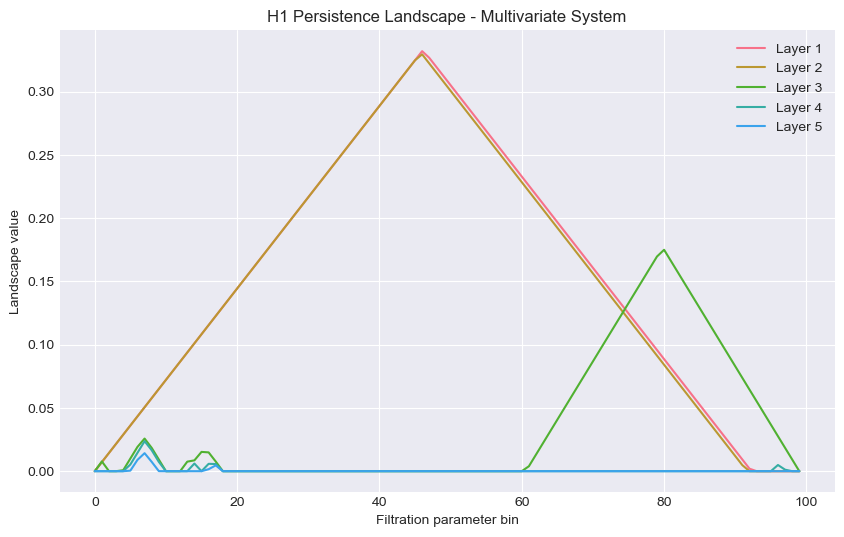

In [6]:
import matplotlib.pyplot as plt

# Multivariate: Plot all layers of H1
n_homology_dims = len(landscape_multi.homology_dimensions_)
n_layers = 5
homology_dim_idx = 1  # H1

fig, ax = plt.subplots(figsize=(10, 6))

for layer in range(n_layers):
    idx = n_homology_dims * homology_dim_idx + layer
    ax.plot(landscapes_multi[0, idx, :], label=f'Layer {layer + 1}')

ax.set_xlabel('Filtration parameter bin')
ax.set_ylabel('Landscape value')
ax.set_title('H1 Persistence Landscape - Multivariate System')
ax.legend()
ax.grid(True)
plt.show()

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, f_oneway
from sklearn.metrics import pairwise_distances

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Your variable names
variable_names = data_norm.columns.tolist()

In [17]:
def compute_basic_statistics(landscapes_uni, variable_names):
    """Compute essential statistics for each variable"""
    
    stats = []
    for i, var_name in enumerate(variable_names):
        landscape = landscapes_uni[i]  # Shape: (15, 100)
        landscape_flat = landscape.flatten()
        
        # Extract by homology dimension
        H0 = landscape[0:5, :].flatten()   # H0: layers 0-4
        H1 = landscape[5:10, :].flatten()  # H1: layers 5-9
        H2 = landscape[10:15, :].flatten() # H2: layers 10-14
        
        stats.append({
            'Variable': var_name,
            'Total_Complexity': np.linalg.norm(landscape_flat),
            'H0_Complexity': np.linalg.norm(H0),
            'H1_Complexity': np.linalg.norm(H1),
            'H2_Complexity': np.linalg.norm(H2),
            'Mean': np.mean(landscape_flat),
            'Std': np.std(landscape_flat),
            'Max': np.max(landscape_flat)
        })
    
    return pd.DataFrame(stats)

# Compute and display
stats_df = compute_basic_statistics(landscapes_uni, variable_names)
print("\n" + "="*80)
print("TOPOLOGICAL COMPLEXITY BY VARIABLE")
print("="*80)
print(stats_df.to_string(index=False, float_format='%.3f'))

# Rank by complexity
print("\n\nRANKED BY TOTAL COMPLEXITY:")
print("-"*60)
ranked = stats_df.sort_values('Total_Complexity', ascending=False)
for i, (_, row) in enumerate(ranked.iterrows(), 1):
    print(f"{i}. {row['Variable']:40s} {row['Total_Complexity']:8.3f}")


TOPOLOGICAL COMPLEXITY BY VARIABLE
                      Variable  Total_Complexity  H0_Complexity  H1_Complexity  H2_Complexity  Mean   Std   Max
              precio_brent_usd             1.008          0.970          0.275          0.006 0.010 0.024 0.122
                  valor_colcap             0.984          0.959          0.218          0.026 0.009 0.024 0.122
Indic_de_precios_al_consumidor             0.071          0.071          0.000          0.000 0.000 0.002 0.021
    Indic_seguimiento_economia             0.961          0.961          0.039          0.004 0.008 0.023 0.123
     Indic_tasa_de_cambio_real             0.777          0.722          0.287          0.010 0.007 0.019 0.103
                tasa_desempleo             2.787          2.783          0.146          0.006 0.033 0.064 0.259
                           pib             0.528          0.469          0.243          0.000 0.004 0.013 0.081


RANKED BY TOTAL COMPLEXITY:
--------------------------------------

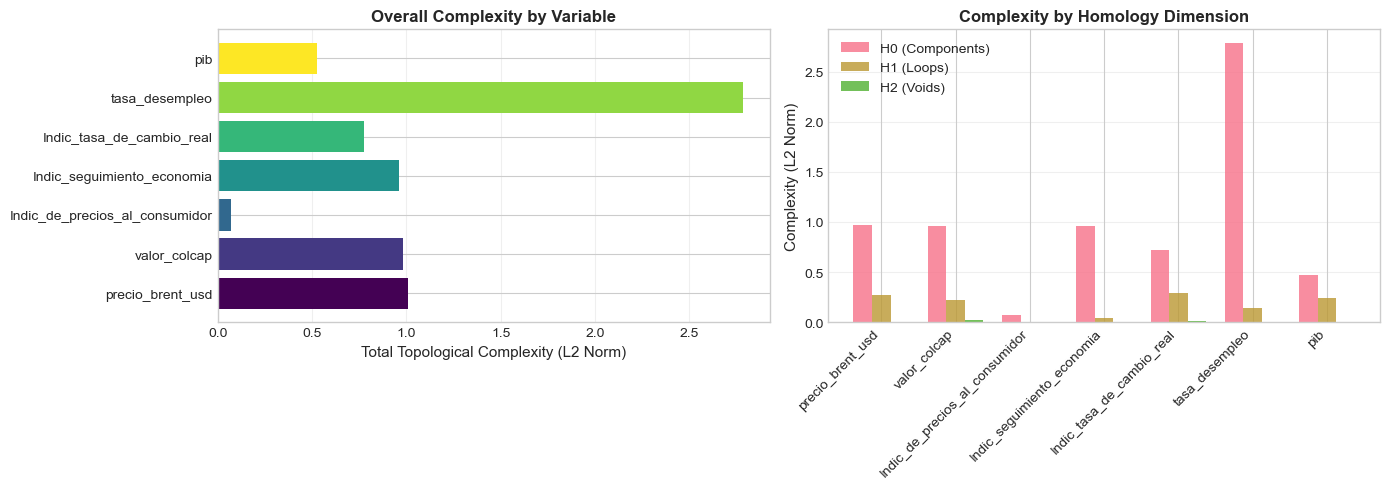

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure with 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Overall complexity bar chart
ax = axes[0]
colors = plt.cm.viridis(np.linspace(0, 1, len(variable_names)))
y_pos = np.arange(len(variable_names))
ax.barh(y_pos, stats_df['Total_Complexity'], color=colors)
ax.set_yticks(y_pos)
ax.set_yticklabels(variable_names)
ax.set_xlabel('Total Topological Complexity (L2 Norm)', fontsize=11)
ax.set_title('Overall Complexity by Variable', fontweight='bold', fontsize=12)
ax.grid(axis='x', alpha=0.3)

# Plot 2: Complexity by homology dimension
ax = axes[1]
x = np.arange(len(variable_names))
width = 0.25

ax.bar(x - width, stats_df['H0_Complexity'], width, label='H0 (Components)', alpha=0.8)
ax.bar(x, stats_df['H1_Complexity'], width, label='H1 (Loops)', alpha=0.8)
ax.bar(x + width, stats_df['H2_Complexity'], width, label='H2 (Voids)', alpha=0.8)

ax.set_ylabel('Complexity (L2 Norm)', fontsize=11)
ax.set_title('Complexity by Homology Dimension', fontweight='bold', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(variable_names, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('complexity_plots.png', dpi=300, bbox_inches='tight')
plt.show()

In [19]:
# Flatten landscapes
landscapes_flat = landscapes_uni.reshape(len(variable_names), -1)

# Compute Euclidean distances
distances = pairwise_distances(landscapes_flat, metric='euclidean')

print("\n" + "="*80)
print("PAIRWISE DISTANCES (Euclidean)")
print("="*80)
dist_df = pd.DataFrame(distances, 
                       index=variable_names, 
                       columns=variable_names)
print(dist_df.to_string(float_format='%.3f'))

# Find most similar and dissimilar pairs
print("\n\nMOST SIMILAR PAIRS:")
print("-"*60)
pairs = []
for i in range(len(variable_names)):
    for j in range(i+1, len(variable_names)):
        pairs.append((variable_names[i], variable_names[j], distances[i, j]))

pairs_sorted = sorted(pairs, key=lambda x: x[2])

for var1, var2, dist in pairs_sorted[:5]:
    print(f"{var1:35s} <-> {var2:35s}  distance = {dist:.3f}")

print("\n\nMOST DISSIMILAR PAIRS:")
print("-"*60)
for var1, var2, dist in pairs_sorted[-5:]:
    print(f"{var1:35s} <-> {var2:35s}  distance = {dist:.3f}")


PAIRWISE DISTANCES (Euclidean)
                                precio_brent_usd  valor_colcap  Indic_de_precios_al_consumidor  Indic_seguimiento_economia  Indic_tasa_de_cambio_real  tasa_desempleo   pib
precio_brent_usd                           0.000         0.111                           1.003                       0.301                      0.443           2.441 0.742
valor_colcap                               0.111         0.000                           0.978                       0.245                      0.445           2.447 0.731
Indic_de_precios_al_consumidor             1.003         0.978                           0.000                       0.956                      0.771           2.785 0.519
Indic_seguimiento_economia                 0.301         0.245                           0.956                       0.000                      0.463           2.445 0.743
Indic_tasa_de_cambio_real                  0.443         0.445                           0.771              

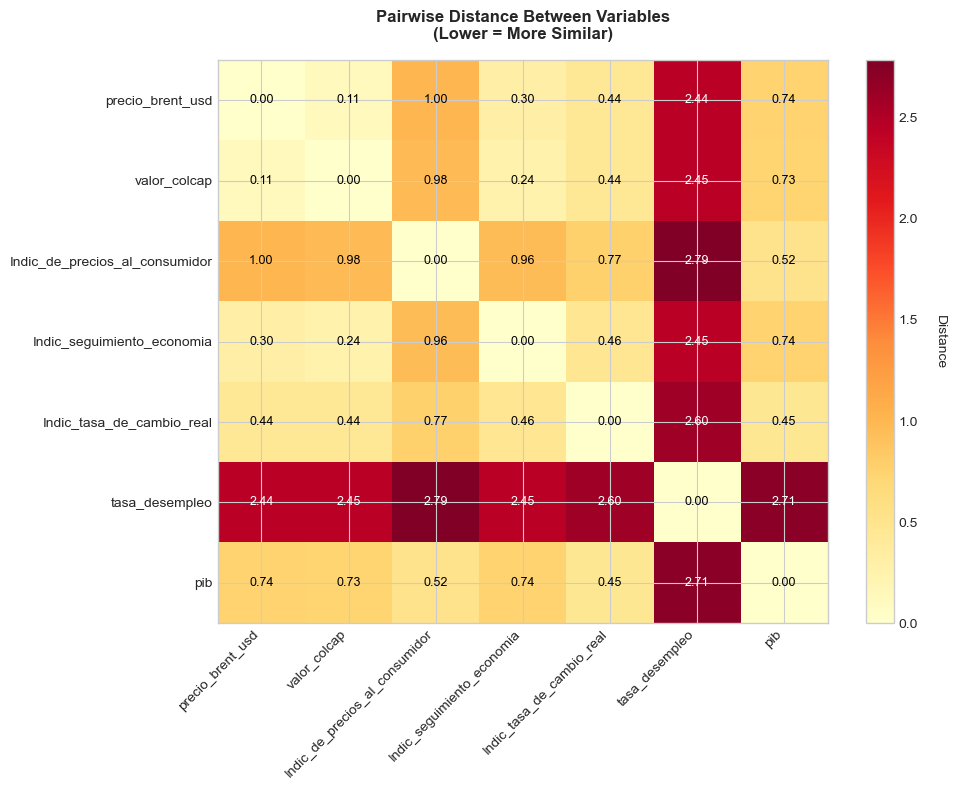

In [20]:
fig, ax = plt.subplots(figsize=(10, 8))

# Create heatmap
im = ax.imshow(distances, cmap='YlOrRd', aspect='auto')

# Labels
ax.set_xticks(np.arange(len(variable_names)))
ax.set_yticks(np.arange(len(variable_names)))
ax.set_xticklabels(variable_names, rotation=45, ha='right')
ax.set_yticklabels(variable_names)

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Distance', rotation=270, labelpad=20)

# Add values to cells
for i in range(len(variable_names)):
    for j in range(len(variable_names)):
        color = "white" if distances[i, j] > distances.max()/2 else "black"
        text = ax.text(j, i, f'{distances[i, j]:.2f}',
                      ha="center", va="center", 
                      color=color, fontsize=9)

ax.set_title('Pairwise Distance Between Variables\n(Lower = More Similar)', 
            fontsize=12, fontweight='bold', pad=15)

plt.tight_layout()
plt.savefig('distance_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

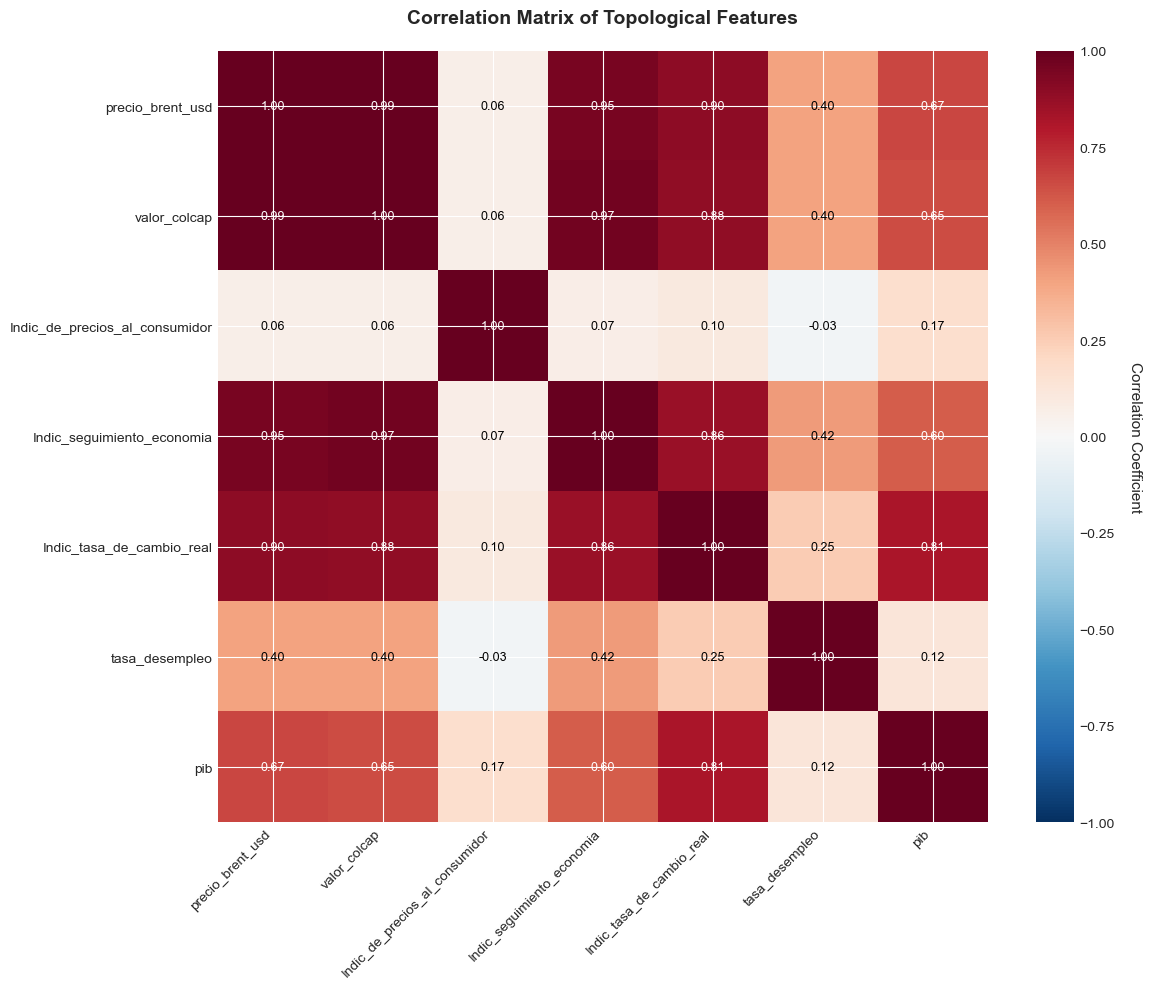


CORRELATION ANALYSIS

Highly Correlated Variables (|r| > 0.7):
------------------------------------------------------------
precio_brent_usd               <-> valor_colcap                    r =  0.993
precio_brent_usd               <-> Indic_seguimiento_economia      r =  0.949
precio_brent_usd               <-> Indic_tasa_de_cambio_real       r =  0.896
valor_colcap                   <-> Indic_seguimiento_economia      r =  0.965
valor_colcap                   <-> Indic_tasa_de_cambio_real       r =  0.884
Indic_seguimiento_economia     <-> Indic_tasa_de_cambio_real       r =  0.864
Indic_tasa_de_cambio_real      <-> pib                             r =  0.815


In [13]:
# Compute correlation between landscape features
correlation_matrix = np.corrcoef(landscapes_flat)

fig, ax = plt.subplots(figsize=(12, 10))

im = ax.imshow(correlation_matrix, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)

ax.set_xticks(np.arange(len(variable_names)))
ax.set_yticks(np.arange(len(variable_names)))
ax.set_xticklabels(variable_names, rotation=45, ha='right')
ax.set_yticklabels(variable_names)

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Correlation Coefficient', rotation=270, labelpad=20, fontsize=11)

# Add values
for i in range(len(variable_names)):
    for j in range(len(variable_names)):
        text = ax.text(j, i, f'{correlation_matrix[i, j]:.2f}',
                     ha="center", va="center",
                     color="white" if abs(correlation_matrix[i, j]) > 0.5 else "black",
                     fontsize=9)

ax.set_title('Correlation Matrix of Topological Features', 
            fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Print highly correlated pairs
print("\n" + "="*80)
print("CORRELATION ANALYSIS")
print("="*80)
print("\nHighly Correlated Variables (|r| > 0.7):")
print("-"*60)

for i in range(len(variable_names)):
    for j in range(i+1, len(variable_names)):
        corr = correlation_matrix[i, j]
        if abs(corr) > 0.7:
            print(f"{variable_names[i]:30s} <-> {variable_names[j]:30s}  r = {corr:6.3f}")

In [21]:
print("\n" + "="*80)
print("SUMMARY")
print("="*80)

print("\n1. TOP 3 MOST TOPOLOGICALLY COMPLEX VARIABLES:")
print("-"*60)
for i, (_, row) in enumerate(ranked.head(3).iterrows(), 1):
    print(f"{i}. {row['Variable']:40s} (complexity = {row['Total_Complexity']:.3f})")

print("\n2. WHICH HOMOLOGY DIMENSION DOMINATES EACH VARIABLE:")
print("-"*60)
for _, row in stats_df.iterrows():
    h_values = [('H0', row['H0_Complexity']), 
                ('H1', row['H1_Complexity']), 
                ('H2', row['H2_Complexity'])]
    dominant = max(h_values, key=lambda x: x[1])
    print(f"{row['Variable']:40s} -> {dominant[0]}")

print("\n3. TOP 3 MOST SIMILAR VARIABLE PAIRS:")
print("-"*60)
for i, (var1, var2, dist) in enumerate(pairs_sorted[:3], 1):
    print(f"{i}. {var1} <-> {var2} (distance = {dist:.3f})")

print("\n" + "="*80)


SUMMARY

1. TOP 3 MOST TOPOLOGICALLY COMPLEX VARIABLES:
------------------------------------------------------------
1. tasa_desempleo                           (complexity = 2.787)
2. precio_brent_usd                         (complexity = 1.008)
3. valor_colcap                             (complexity = 0.984)

2. WHICH HOMOLOGY DIMENSION DOMINATES EACH VARIABLE:
------------------------------------------------------------
precio_brent_usd                         -> H0
valor_colcap                             -> H0
Indic_de_precios_al_consumidor           -> H0
Indic_seguimiento_economia               -> H0
Indic_tasa_de_cambio_real                -> H0
tasa_desempleo                           -> H0
pib                                      -> H0

3. TOP 3 MOST SIMILAR VARIABLE PAIRS:
------------------------------------------------------------
1. precio_brent_usd <-> valor_colcap (distance = 0.111)
2. valor_colcap <-> Indic_seguimiento_economia (distance = 0.245)
3. precio_brent_usd <